In [100]:
import numpy as np

In [101]:
# 곱셈 계층 역전파(딥러닝 2. 신경망학습 교안 p.39)
class MulLayer:
  def __init__(self):
    self.X = None
    self.y = None

  # forward
  def forward(self,x, y):
    self.x = x
    self.y = y
    return x * y
  
  # backward
  # dout : 상류에서 흘러오는 값
  def backward(self, dout):
    dx = dout * self.y
    dy = dout * self.x
    return dx, dy

In [102]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward 전방향
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward 역방향
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(f"price : {price}")
print(f"dapple : {dapple}") #미분한 값
print(f"dapple_num : {dapple_num}")
print(f"dtax : {dtax}")

price : 220.00000000000003
dapple : 2.2
dapple_num : 110.00000000000001
dtax : 200


In [103]:
# 곱셈&덧셈 계층 역전파(딥러닝 2. 신경망학습 교안 p.40)
# 위에서 만든 곱셈 클래스 활용
# 덧셈 클래스 생성
class AddLayer:
  #위 MulLayer에서 초기화했으니 초기화할 필요 없음

  # forward
  def forward(self, x, y):
    return x + y

  # backward
  # dout : 상류에서 흘러오는 값
  def backward(self, dout):
    dx = dout
    dy = dout
    return dx, dy

In [104]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계산과정 4번이므로 4개 계층 만들어줌
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
mul_tax_layer = MulLayer()
add_ao_layer = AddLayer()

# forward (전방향)
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
sum_price = add_ao_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(sum_price, tax)

# backward (역방향)
dprice = 1
dsum_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_ao_layer.backward(dsum_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(f"price : {price}")
print(f"dapple : {dapple}")
print(f"dapple_num : {dapple_num}")
print(f"dorange : {dorange}")
print(f"dorange_num : {dorange_num}")
print(f"dtax : {dtax}")

price : 715.0000000000001
dapple : 2.2
dapple_num : 110.00000000000001
dorange : 3.3000000000000003
dorange_num : 165.0
dtax : 650


Relu 역전파

In [105]:
# x > 0이면 그대로, x <= 0이면 0으로 만들기
class Relu:
  def __init__(self):
    self.mask = None
  
  def forward(self, x):
    self.mask = (x <= 0) # 입력이 0이냐 0이 아니냐에 대한 정보
    out = x.copy()
    out[self.mask] = 0 # 0보다 작거나 같은 애들 인덱스로 가져와서 0으로 만들어줌
    return out

  def backward(self, dout):
    dout[self.mask] = 0 # y를 가지고 미분한 값이므로 0보다 작은 값 있을 수 있음
    dx = dout
    return dx

Sigmoid 역전파 - 교안 p.45

In [106]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [107]:
# sigmoid 노드 정의
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    self.out = sigmoid(x) #sigmoid 통과한 y
    return self.out

  def backward(self, dout):
    dx = dout * self.out * (1 - self.out)
    return dx

배치용 Affine 계층 역전파 (교안 p.49) => X * W + B

In [123]:
class Affine:
  def __init__(self, W, b): # W는 입력값의 개수와 맞아야 함, b는 출력값의 개수와 맞아야 함
    self.W = W
    self.b = b

    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x): #W, b는 위에 있으니까 x만!
    self.x = x
    
    out = np.dot(self.x, self.W) + self.b
    return out

  def backward(self, dout): # dout : 상류에서 흘러내려온 값
    dx = np.dot(dout, self.W.T) # 1번과정

    self.dW = np.dot(self.x.T, dout) # 2번과정
    self.db = np.sum(dout, axis=0) # 3번과정

    return dx # 미분한 값을 흘려 보내줘야 다음 값의 input으로 들어갈 수 있음

In [124]:
def softmax(x):
  exp_x = np.exp(x)
  sum_exp_x = np.sum(exp_x, axis=-1).reshape(-1,1)
  #axis=-1인 이유; 맨 마지막에 있는 차원을 기준으로 구하기 위함??
  #np.array([[0, 1, 3], [0, 5, 4]]).shape -> (2,3)인데 여기서 3을 기준으로 계산하기 위함

  y = exp_x / sum_exp_x
  
  return y

In [125]:
def cross_entropy_error(y,t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size) #원래 y.size는 (10,) -> shape 통과시키면 (1,10)

  batch_size = y.shape[0]
  #batch_size는 sample의 개수만큼 나눠줘야 하는 것
  
  delta = 1e-7
  return -np.sum(t * np.log(y + delta)) / batch_size
  #각각에 대한 확률값 구하기 위해 batch_size로 나눠줘야 함

In [126]:
class SoftmaxWithLoss():
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t): #x: 입력값, t: 라벨
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1): # 맨마지막 단의 dout은 1이었음
    batch_size = self.t.shape[0]

    if self.t.size == self.y.size: #y는 원핫 형태; t가 라벨 인코딩되어 있다면 00010 이런식으로 바꿔줘야 함
      dx = (self.y - self.t) / batch_size #둘다 원핫일 경우
    else: #라벨인코딩 있을 경우
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size
    return dx

In [127]:
def _numerical_gradient_no_batch(f,w): #여기서 x는 가중치!
  h = 1e-4
  grad = np.zeros_like(w)
  
  for idx in range(w.size):
    tmp_val = w[idx] #n번째 가중치

    #f(w+h)
    w[idx] = float(tmp_val) + h
    fxh1 = f(w)

    #f(w-h)
    w[idx] = float(tmp_val) - h
    fxh2 = f(w)

    grad[idx] = (fxh1 - fxh2) / (2 * h)
    w[idx] = tmp_val

  return grad

In [128]:
def numerical_gradient(f,W): #여기서 X는 가중치(weight)!
  #샘플 1개인 경우는 그냥 호출
  if W.ndim == 1:
    return _numerical_gradient_no_batch(f,W)
  
  #샘플 여러개 한꺼번에 들어온 경우: batch_size = 2
  else:
    grad = np.zeros_like(W)
    
    for idx, W in enumerate(W):
      grad[idx] = _numerical_gradient_no_batch(f,W)

    return grad

In [130]:
from collections import OrderedDict

class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    #파라미터 랜덤 초기화
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    self.layers = OrderedDict() #정렬된 딕셔너리
    self.layers["Affine1"] = Affine(self.params['W1'], self.params['b1'])
    self.layers["Relu1"] = Relu() #입력값 없음
    self.layers["Affine2"] = Affine(self.params['W2'], self.params['b2'])
    self.lastlayer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x #softmax 들어가기 전의 값(logit)

  def loss(self, x, t):
    y = self.predict(x)
    return self.lastlayer.forward(y, t) #softmaxwithloss에 들어가서 교차엔트로피 통과시켜 loss 반환

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1:
      t = np.argmax(t, axis=1) #열에 대해 argmax

    accuracy = np.sum(y == t) / float(x.shape[0]) #sample 개수만큼 나눠서 평균 구함
    return accuracy

  #각 파라미터의 기울기 구하기
  def numerical_gradient(self, x, t):
    #목적 함수 - cross entropy
    loss_W = lambda W : self.loss(x, t)

    grads = {}
    #목적함수에 대해 각 파라미터 별로 편미분
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    return grads

  def gradient(self, x, t):
    self.loss(x, t)

    dout = 1
    dout = self.lastlayer.backward(dout) #마지막단의 역전파 오류값 구해짐

    layers = list(self.layers.values())
    layers.reverse()

    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    #편미분 안하고 backward 하면서 계산한 값 하나씩 가져옴
    grads['W1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].db
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db

    return grads

In [131]:
import pickle
def load_mnist(normalize=True, flatten=True, one_hot_label=False):
  def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T): #60000개의 row를 하나씩 던져줌
      row[X[idx]] = 1 #label에 해당하는 값에 1 - 0000010000 이런식으로 만들어주기

    return T

  with open('/content/drive/MyDrive/mnist.pkl', 'rb') as f:
    dataset = pickle.load(f)

  if normalize: #이미지 읽어서 정규화
    for key in ('train_img', 'test_img'):
      dataset[key] = dataset[key].astype(np.float32)
      dataset[key] /= 255.0 #기존 데이터는 0-256까지 정수값 가지고 있음 ->0~1사이 값으로 표현

  if one_hot_label: #one-hot encoding
    dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
    dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    #60000개 숫자를 10개로 만들어줌
  
  if not flatten:
    for key in ('train_img', 'test_img'):
      dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

  return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

In [132]:
#데이터 로딩 - 원핫 형식으로
(x_train, y_train), (x_test, y_test) = load_mnist(normalize=True, flatten=True, one_hot_label=True)

In [133]:
#2층 신경망 객체 생성
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [134]:
iters_num = 10000 #반복 횟수
train_size = x_train.shape[0] #훈련 데이터 크기
batch_size = 100 #미니배치 사이즈
learning_rate = 0.01 #학습률

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1) #1 에폭당 반복 횟수. 최소 한번
#한 에폭은 전체 데이터 개수 60000개, 배치는 그걸 자른 것
#배치 사이즈 0될 수도 있으니까 1을 줘야 함

In [139]:
#loss 점점 줄어드는 걸 보기 위함
for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  #랜덤하게 0 ~ train_size-1 안에 있는 숫자를 batch_size만큼 가져옴
  #index 반환. 중복 가능

  x_batch = x_train[batch_mask] #랜덤으로 배치사이즈만큼 훈련 데이터에서 선택
  y_batch = y_train[batch_mask] #랜덤으로 배치사이즈만큼 라벨에서 선택

  #각 파라미터의 gradient 계산
  grad = network.gradient(x_batch, y_batch)

  #각 파라미터를 업데이트 (ex. w = w - 학습률 * 기울기)
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

    #loss 구하기
    loss = network.loss(x_batch, y_batch)
    train_loss_list.append(loss) #loss 값을 train_loss_list에 추가

    if i % iter_per_epoch == 0:
    #정확도 검사할 때는 batch가 아니라 전체 데이터 넣어줘야 함
      #파라미터 업데이트 후의 훈련 데이터 정확도
      train_acc = network.accuracy(x_train, y_train) #전체 데이터 accuracy
      #파라미터 업데이트 후의 테스트 데이터 정확도 - 안 본 데이터에 대한 정확도
      test_acc = network.accuracy(x_test, y_test)

      train_acc_list.append(train_acc) #accuracy 값을 train_acc_list에 추가
      test_acc_list.append(test_acc) #accuracy 값을 test_acc_list에 추가

      print(f"loss {loss}, train_accuracy{train_acc}, test_accuracy{test_acc}")


loss 0.25016748846963366, train_accuracy0.9186333333333333, test_accuracy0.9212
loss 0.2501510847518174, train_accuracy0.9186333333333333, test_accuracy0.9212
loss 0.24950272240527827, train_accuracy0.9186833333333333, test_accuracy0.9211
loss 0.24949553859911228, train_accuracy0.9186833333333333, test_accuracy0.9211
loss 0.24997857146226415, train_accuracy0.92065, test_accuracy0.9242
loss 0.2499629257685171, train_accuracy0.9206333333333333, test_accuracy0.9242
loss 0.24896929301546677, train_accuracy0.9205333333333333, test_accuracy0.924
loss 0.2489623170919413, train_accuracy0.9205333333333333, test_accuracy0.924
loss 0.3764329030766481, train_accuracy0.9224833333333333, test_accuracy0.9243
loss 0.3763841429659092, train_accuracy0.9225, test_accuracy0.9243
loss 0.3734117513505518, train_accuracy0.9224, test_accuracy0.9239
loss 0.3733875124672399, train_accuracy0.9224, test_accuracy0.9238
loss 0.15827354306904323, train_accuracy0.9229333333333334, test_accuracy0.9247
loss 0.158249259

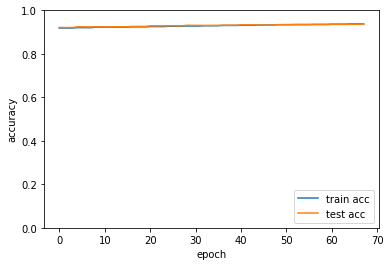

In [140]:
import matplotlib.pylab as plt

x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label="train acc")
plt.plot(x, test_acc_list, label="test acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc="lower right") #범례 위치 지정
plt.show()